In [1]:
import numpy as np
import pylab as plt
from math import *
from collections import defaultdict
import random
import pandas as pd

## Globals and Mappings

In [2]:
## payoffs for different PD

payoff_map_1 = {
    
    ## Reward for both cooperate
    'R': 5,
    
    ## Sucker cooperate alone
    'S': 1,
    
    ## Tempation to defect alone
    'T': 10,
    
    ## Punishment when both defect
    'P': 2,
    
}


In [3]:
payoff_map_2 = {
    
    ## Reward for both cooperate
    'R': 9,
    
    ## Sucker cooperate alone
    'S': 1,
    
    ## Tempation to defect alone
    'T': 10,
    
    ## Punishment when both defect
    'P': 2,
}
    

In [4]:
payoff_map_3 = {
    
    ## Reward for both cooperate
    'R': 3,
    
    ## Sucker cooperate alone
    'S': 1,
    
    ## Tempation to defect alone
    'T': 100,
    
    ## Punishment when both defect
    'P': 2,
}
    

In [121]:
payoff_map_4 = {
    
    ## Reward for both cooperate
    'R': 5,
    
    ## Sucker cooperate alone
    'S': 1,
    
    ## Tempation to defect alone
    'T': 6,
    
    ## Punishment when both defect
    'P': 4,
}
    

## Small Brain Agents

In [5]:
class agent:
    
    def __init__(self, ID, N):
        
        self.ID = ID
        
        ##prob that this agent will cooperate
        self.initial_coop_ratio = ID / N
        
        ##how much this person pays out
        self.total_payout = 0
        
        ## history of other players, we'll save timestamps and actions
        self.other_history = defaultdict(list)
        
        
        ## checks whether on probation or not
        self.probation = False
        
        
    ## for now, everyone will play fixed strategy by ratio of cooperation    
    def strategy(self):
        
        if self.initial_coop_ratio > random.random():
            return 'C'
        
        return 'D'
        
        
        
        
        

In [21]:
class run_simulation:
    
    
    def __init__(self, num_players, periods, payout_map, punish_time, memory_adjustment=False):
        
        
        self.N = num_players
        self.T = periods
        self.payout_map = payout_map
        
        ##let punish time also be number of periods we play until new vote
        self.punish_time = punish_time
        self.decay_memory = memory_adjustment
        
        ##create agents vector
        self.agents_vec = []
        for i in range(self.N):
            new_agent = agent(i, self.N)
            self.agents_vec.append(new_agent)
    
    def run(self):
        
        for t in range(self.T):
                
            ## if in right period vote
            if t%self.punish_time == 0:
                self.vote(t)
            
            
            ## play the game
            
            #initialize map of all players
            unpaired_players = set(np.arange(self.N))
            
            ## let them play
            while len(unpaired_players) > 1:
                p1_ID = random.sample(unpaired_players, 1)[0]
                unpaired_players.remove(p1_ID)
                p2_ID = random.sample(unpaired_players, 1)[0]
                unpaired_players.remove(p2_ID)
                
                p1 = self.agents_vec[p1_ID]
                p2 = self.agents_vec[p2_ID]
            
                self.update_agents(p1, p2, t)
            
            
    def update_agents(self, p1, p2, time):
        
        ## let's normalize cooperate as 1 and default as -1
        choice_map = {
            'C': 1,
            'D': -1
        }
        
        
        ## they play
        p1_choice = p1.strategy()
        p2_choice = p2.strategy()
        
        ## however if one of them is on probation switch strategy to defect
        if p1.probation == True:
            p2_choice = 'D'
        if p2.probation == True:
            p1_choice = 'D'
        
        
        ## they update
        p1.other_history[p2.ID].append(np.array([time, choice_map[p2_choice]]))
        p2.other_history[p1.ID].append(np.array([time, choice_map[p1_choice]]))
    
        payouts = self.calculate_payouts(p1_choice, p2_choice)
        p1.total_payout += payouts[0]
        p2.total_payout += payouts[1]
        
        
    def calculate_payouts(self, p1_choice, p2_choice):
        
        ## both cooperate
        if p1_choice == 'C' and p2_choice == 'C':
            return (self.payout_map['R'], self.payout_map['R'])
        
        ## both defect
        elif p1_choice == 'D' and p2_choice == 'D':
            return (self.payout_map['P'], self.payout_map['P'])
        
        ## p1 cooperates and p2 defects
        elif p1_choice == 'C' and p2_choice == 'D':
            return (self.payout_map['S'], self.payout_map['T'])
        
        ## p2 cooperates and p1 defects
        else:
            return (self.payout_map['T'], self.payout_map['S'])
    
    def vote(self, cur_t):
        ## note that people on probation do not get to vote
        ## at this interval, people get a binary vote on whether or not they want to put someone on probation
        ## if a majority agree then they are, else they are not
        
        for agent in self.agents_vec:
            cur_ID = agent.ID
            votes_for = 0
            votes_against = 0
            
            ##loop through agents
            for voter in self.agents_vec:
                
                ## skip if you are on probation and can't vote for yourself
                if voter.probation == True or voter.ID == cur_ID:
                    continue
            
                ## access your history with this guy
                history = voter.other_history[cur_ID]
                
                ## simple history
                score = 0
                if self.decay_memory == False:
                    if len(history) > 0:
                        score = sum(history)[1]
                
                ##  decay history
                else:
                    score = 0
                    for pair in history:
                        w = 0.9**(cur_t - pair[0])
                        score += w*pair[1]
                        
                ## ????clear history after voting
                #history = []
                        
                if score < 0:
                    votes_against += 1
                else:
                    votes_for += 1
                    
            ## determine whether this agent should be put on prob or not
            if votes_against > votes_for:
                agent.probation = True
            else:
                agent.probation = False
                
                
    def summarize(self):
        
        self.summary_list = []
        
        
        for a in self.agents_vec:
            coop_ratio = a.initial_coop_ratio
            payout = a.total_payout
            
            new_entry = {
                'Cooperation_Ratio': coop_ratio,
                'Final_Payout': payout
            }
            self.summary_list.append(new_entry)
            
        self.summary_df = pd.DataFrame(self.summary_list)
        
    def graph_results(self):
        
        
        plt.plot(self.summary_df['Cooperation_Ratio'], self.summary_df['Final_Payout'], '.-')
        
        
        p_map = self.payout_map
        
        title_str = "R = {}, S = {}, T = {}, P = {}, num_agents = {}, periods = {}, punish_time = {}, memory_decay = {}\
        ".format(p_map['R'],p_map['S'],p_map['T'],p_map['P'], self.N, self.T, self.punish_time, self.decay_memory)
        
        
        plt.title(title_str)
        plt.xlabel('Cooperation Ratio')
        plt.ylabel('Final Payout')
    
        total_util = sum(self.summary_df['Final_Payout'])
        print('Total Payout', total_util)
        plt.show()

## Nice guys finish last (or not)??

In [22]:
class nice_agents(agent):
    def __init__(self, ID, N):
        super().__init__(ID, N)
        self.initial_coop_ratio = (self.initial_coop_ratio + 1) / 2

In [23]:
class run_nice_simulation(run_simulation):
    def __init__(self, num_players, periods, payout_map, punish_time, memory_adjustment=False):
        super().__init__(num_players, periods, payout_map, punish_time, memory_adjustment)
        ##create agents vector
        self.agents_vec = []
        for i in range(self.N):
            new_agent = nice_agents(i, self.N)
            self.agents_vec.append(new_agent)
        
        
    
    

## Doing it

Total Payout 770


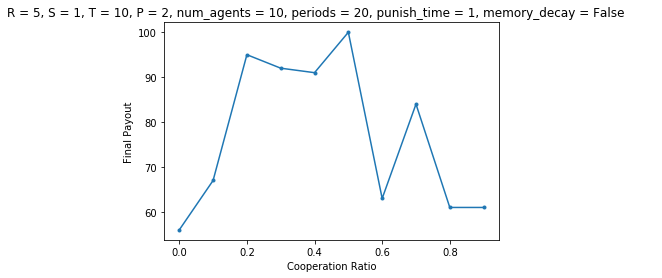

In [24]:
simulate_1 = run_simulation(10, 20, payoff_map_1, 1)

simulate_1.run()

simulate_1.summarize()

simulate_1.graph_results()

Total Payout 164520


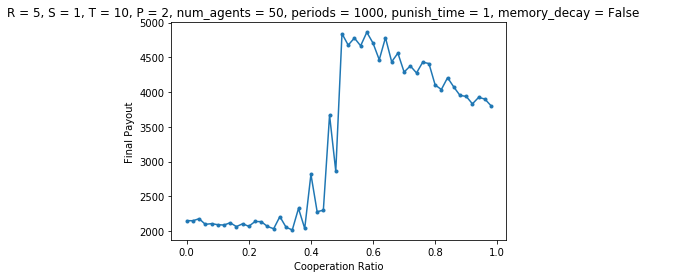

In [25]:
simulate_11 = run_simulation(50, 1000, payoff_map_1, 1, False)
simulate_11.run()
simulate_11.summarize()
simulate_11.graph_results()

Total Payout 158715


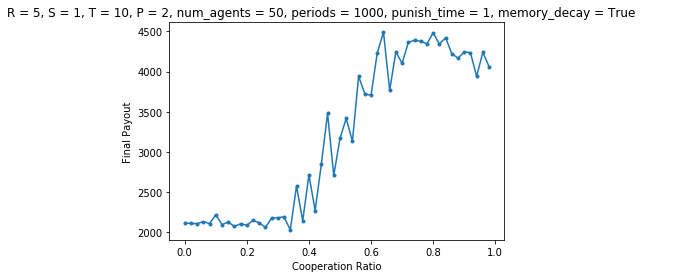

In [26]:
simulate_12 = run_simulation(50, 1000, payoff_map_1, 1, True)
simulate_12.run()
simulate_12.summarize()
simulate_12.graph_results()

True

Total Payout 1595434


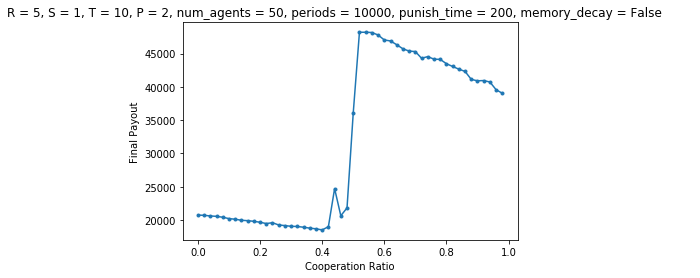

In [28]:
simulate_2 = run_simulation(50, 10000, payoff_map_1, 200, False)
simulate_2.run()
simulate_2.summarize()
simulate_2.graph_results()

Total Payout 2236419


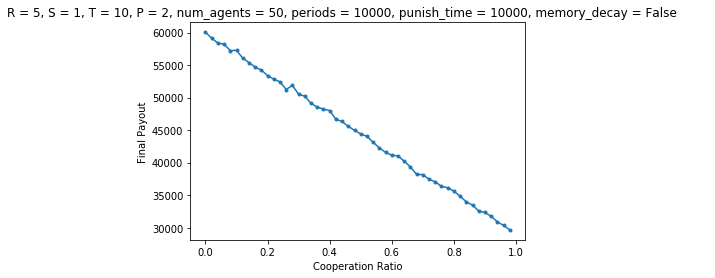

In [29]:
simulate_2_dumb = run_simulation(50, 10000, payoff_map_1, 10000, False)
simulate_2_dumb.run()
simulate_2_dumb.summarize()
simulate_2_dumb.graph_results()

Total Payout 1601531


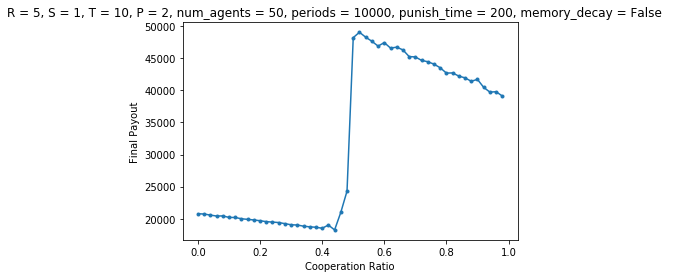

In [47]:
simulate_2_dumb2 = run_simulation(50, 10000, payoff_map_1, 200, False)
simulate_2_dumb2.run()
simulate_2_dumb2.summarize()
simulate_2_dumb2.graph_results()

Total Payout 1560720


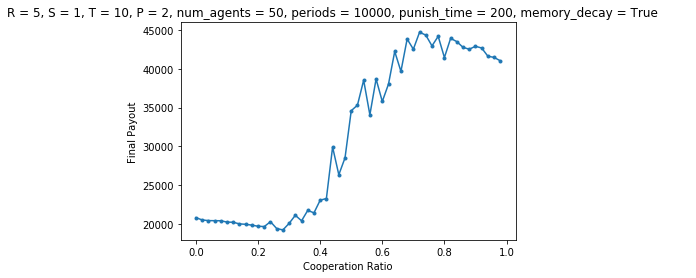

In [31]:
simulate_3 = run_simulation(50, 10000, payoff_map_1, 200, True)
simulate_3.run()
simulate_3.summarize()
simulate_3.graph_results()

Total Payout 1872907


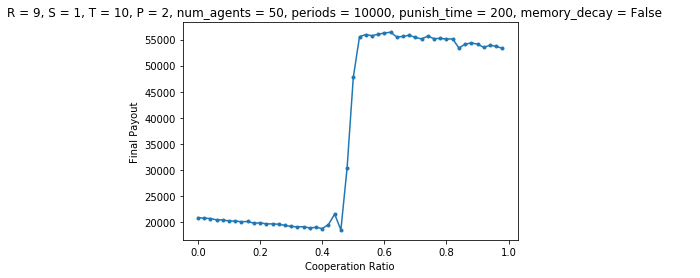

In [32]:
simulate_4 = run_simulation(50, 10000, payoff_map_2, 200, False)
simulate_4.run()
simulate_4.summarize()
simulate_4.graph_results()

Total Payout 1781004


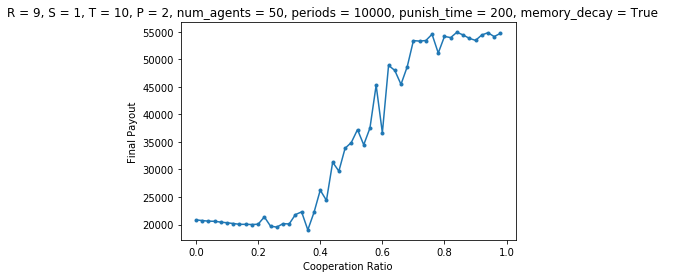

In [33]:
simulate_5 = run_simulation(50, 10000, payoff_map_2, 200, True)
simulate_5.run()
simulate_5.summarize()
simulate_5.graph_results()

Total Payout 2553079


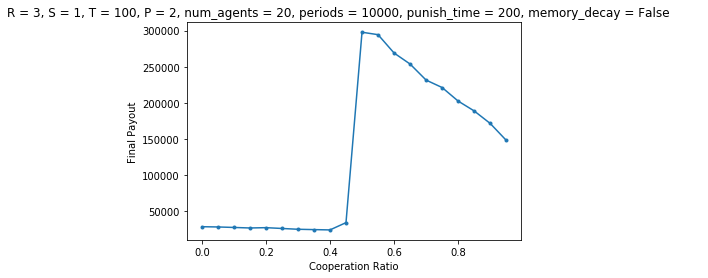

In [34]:
simulate_6 = run_simulation(20, 10000, payoff_map_3, 200, False)
simulate_6.run()
simulate_6.summarize()
simulate_6.graph_results()

Total Payout 6500707


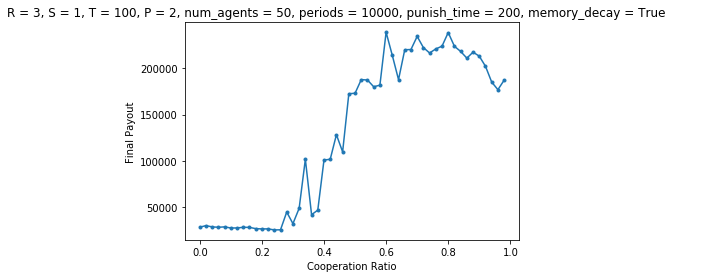

In [48]:
simulate_6T = run_simulation(50, 10000, payoff_map_3, 200, True)
simulate_6T.run()
simulate_6T.summarize()
simulate_6T.graph_results()

## Nice guys run

Total Payout 2490547


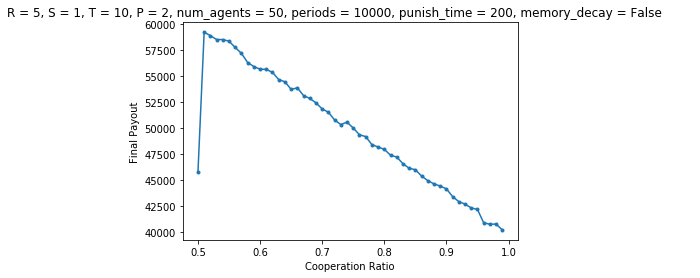

In [35]:
simulate_7 = run_nice_simulation(50, 10000, payoff_map_1, 200, False)
simulate_7.run()
simulate_7.summarize()
simulate_7.graph_results()

Total Payout 2432521


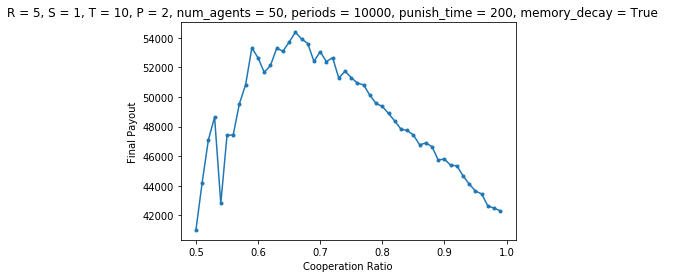

In [36]:
simulate_8 = run_nice_simulation(50, 10000, payoff_map_1, 200, True)
simulate_8.run()
simulate_8.summarize()
simulate_8.graph_results()

Total Payout 2419226


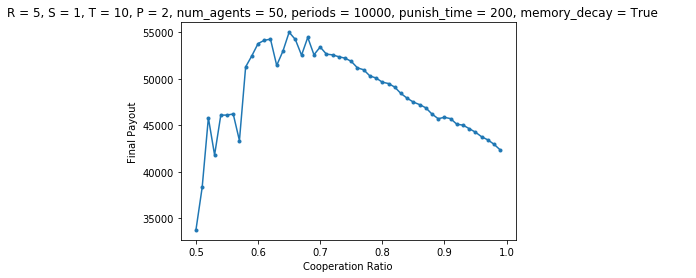

In [37]:
simulate_8_again = run_nice_simulation(50, 10000, payoff_map_1, 200, True)
simulate_8_again.run()
simulate_8_again.summarize()
simulate_8_again.graph_results()

Total Payout 3403793


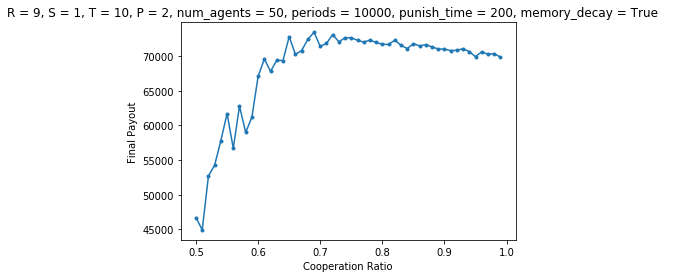

In [38]:
simulate_9 = run_nice_simulation(50, 10000, payoff_map_2, 200, True)
simulate_9.run()
simulate_9.summarize()
simulate_9.graph_results()

Total Payout 10686751


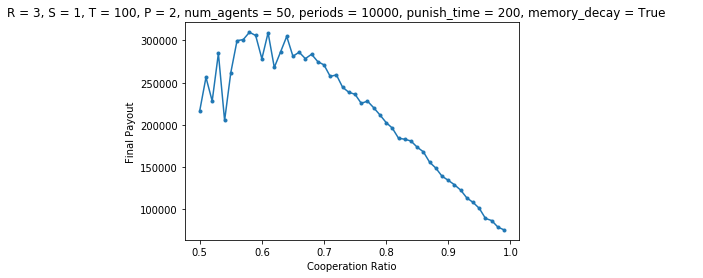

In [39]:
simulate_10 = run_nice_simulation(50, 10000, payoff_map_3, 200, True)
simulate_10.run()
simulate_10.summarize()
simulate_10.graph_results()

In [40]:
## vote against everyone who has a lower threshold than you

Total Payout 2428158


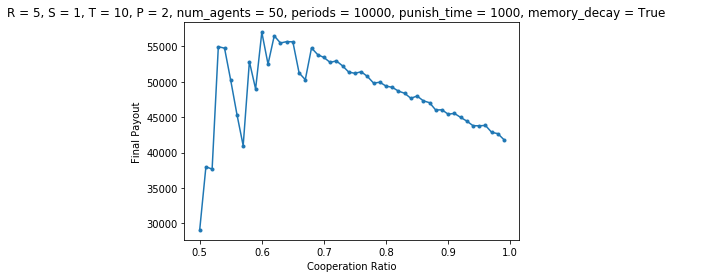

In [41]:
simulate_811 = run_nice_simulation(50, 10000, payoff_map_1, 1000, True)
simulate_811.run()
simulate_811.summarize()
simulate_811.graph_results()

In [42]:
## vote by percentage in which they actually vote for you

In [43]:
## change strategy is if labelled as defector, then cooperate for this period

In [44]:
## distributed justice


In [45]:
## reputation system pay your dues

In [ ]:
## voting google search

In [ ]:
## friedman resnick 2007 reputation system

In [ ]:
## analyze equilibria

In [ ]:
## social welfare optimal threshold

In [ ]:
## dynamically calculate what your treshold for against should be given your own ratio

In [ ]:
## people just vote personal value and can change global need to vote you out

In [49]:
## payoffs for different PD

payoff_map_1 = {
    
    ## Reward for both cooperate
    'R': 5,
    
    ## Sucker cooperate alone
    'S': 1,
    
    ## Tempation to defect alone
    'T': 10,
    
    ## Punishment when both defect
    'P': 2,
    
}


In [111]:
class big_brain_agent:
    
    def __init__(self, ID, N):
        
        self.ID = ID
        
        ##prob that this agent will cooperate
        self.initial_coop_ratio = ID / N
        
        ##how much this person pays out
        self.total_payout = 0
        
        ## history of other players, we'll save timestamps and actions
        self.other_history = defaultdict(list)
        
        
        ## checks whether on probation or not
        self.probation = False
        
        
    ## for now, everyone will play fixed strategy by ratio of cooperation    
    def strategy(self):
        
        if self.initial_coop_ratio > random.random():
            return 'C'
        
        return 'D'
        
        
        
        
        

In [131]:
def smart_vote(my_coop, their_coop, R, P, S, T):
    
    #ratio = (my_coop * (P - S) + T) / (my_coop*(R+P-S-T) + 2*(T - P)) 
    
    ratio = (P-S) / (R+P-S-T) 
    #print(ratio)
    if their_coop < ratio:
        return ratio, 'D'
    
    else:
        return ratio, 'C'
    
    

In [150]:
class run_big_brain:
    
    
    def __init__(self, num_players, periods, payout_map, punish_time, memory_adjustment=False):
        
        
        self.N = num_players
        self.T = periods
        self.payout_map = payout_map
        
        ##let punish time also be number of periods we play until new vote
        self.punish_time = punish_time
        self.decay_memory = memory_adjustment
        
        ##create agents vector
        self.agents_vec = []
        for i in range(self.N):
            new_agent = big_brain_agent(i, self.N)
            self.agents_vec.append(new_agent)
    
    def run(self):
        
        for t in range(self.T):
                
            ## if in right period vote
            if t%self.punish_time == 0 and t != 0:
                self.vote(t)
            
            
            ## play the game
            
            #initialize map of all players
            unpaired_players = set(np.arange(self.N))
            
            ## let them play
            while len(unpaired_players) > 1:
                p1_ID = random.sample(unpaired_players, 1)[0]
                unpaired_players.remove(p1_ID)
                p2_ID = random.sample(unpaired_players, 1)[0]
                unpaired_players.remove(p2_ID)
                
                p1 = self.agents_vec[p1_ID]
                p2 = self.agents_vec[p2_ID]
            
                self.update_agents(p1, p2, t)
            
            
    def update_agents(self, p1, p2, time):
        
        ## let's normalize cooperate as 1 and default as -1
        choice_map = {
            'C': 1,
            'D': -1
        }
        
        
        ## they play
        p1_choice = p1.strategy()
        p2_choice = p2.strategy()
        
        ## however if one of them is on probation switch strategy to defect
        if p1.probation == True:
            p2_choice = 'D'
        if p2.probation == True:
            p1_choice = 'D'
        
        
        ## they update
        p1.other_history[p2.ID].append(choice_map[p2_choice])
        p2.other_history[p1.ID].append(choice_map[p1_choice])
    
        payouts = self.calculate_payouts(p1_choice, p2_choice)
        p1.total_payout += payouts[0]
        p2.total_payout += payouts[1]
        
        
    def calculate_payouts(self, p1_choice, p2_choice):
        
        ## both cooperate
        if p1_choice == 'C' and p2_choice == 'C':
            return (self.payout_map['R'], self.payout_map['R'])
        
        ## both defect
        elif p1_choice == 'D' and p2_choice == 'D':
            return (self.payout_map['P'], self.payout_map['P'])
        
        ## p1 cooperates and p2 defects
        elif p1_choice == 'C' and p2_choice == 'D':
            return (self.payout_map['S'], self.payout_map['T'])
        
        ## p2 cooperates and p1 defects
        else:
            return (self.payout_map['T'], self.payout_map['S'])
    
    def vote(self, cur_t):
        ## note that people on probation do not get to vote
        ## at this interval, people get a binary vote on whether or not they want to put someone on probation
        ## if a majority agree then they are, else they are not
        
        for agent in self.agents_vec:
            cur_ID = agent.ID
            votes_for = 0
            votes_against = 0
            
            ##loop through agents
            for voter in self.agents_vec:
                
                ## skip if you are on probation and can't vote for yourself
                if voter.probation == True:
                    
                    ## clear history
                    #voter.other_history[cur_ID] = []
                    
                    continue
            
                ## access your history with this guy
                history = voter.other_history[cur_ID]
                count_C = history.count(1)
                count_D = history.count(-1)
                
                ### change voting strategy here
                R = self.payout_map['R']
                S = self.payout_map['S']
                T = self.payout_map['T']
                P = self.payout_map['P']
                
                if count_C + count_D < 1:
                    decision = 'C'
                
                else:
                    self.ratio, decision = smart_vote(voter.initial_coop_ratio, count_C / (count_C + count_D), R, P, S, T)
                    print(self.ratio, decision)
                
                if decision == 'D':
                    votes_against += 1
                else:
                    votes_for += 1

                ## ????clear history after voting
                #voter.other_history[cur_ID] = []
                    
            ## determine whether this agent should be put on prob or not
            if votes_against > votes_for:
                agent.probation = True
            else:
                agent.probation = False
                
                
    def summarize(self):
        
        self.summary_list = []
        
        
        for a in self.agents_vec:
            coop_ratio = a.initial_coop_ratio
            payout = a.total_payout
            
            new_entry = {
                'Cooperation_Ratio': coop_ratio,
                'Final_Payout': payout
            }
            self.summary_list.append(new_entry)
            
        self.summary_df = pd.DataFrame(self.summary_list)
        
    def graph_results(self):
        
        
        plt.plot(self.summary_df['Cooperation_Ratio'], self.summary_df['Final_Payout'], '.-')
        
        
        p_map = self.payout_map
        
        title_str = "R = {}, S = {}, T = {}, P = {}, num_agents = {}, periods = {}, punish_time = {}, memory_decay = {}\
        ".format(p_map['R'],p_map['S'],p_map['T'],p_map['P'], self.N, self.T, self.punish_time, self.decay_memory)
        
        
        plt.title(title_str)
        plt.xlabel('Cooperation Ratio')
        plt.ylabel('Final Payout')
    
        total_util = sum(self.summary_df['Final_Payout'])
        print('Total Payout', total_util)
        plt.show()
        print('Ratio', self.ratio)

Total Payout 2237778


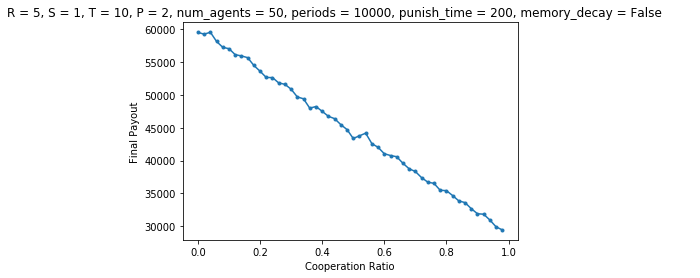

Ratio -0.25


In [133]:
bb_1 = run_big_brain(50, 10000, payoff_map_1, 200, False)
bb_1.run()
bb_1.summarize()
bb_1.graph_results()

In [ ]:
bb_1 = run_big_brain(50, 10000, payoff_map_2, 200, False)
bb_1.run()
bb_1.summarize()
bb_1.graph_results()

In [ ]:
bb_1 = run_big_brain(50, 10000, payoff_map_3, 200, False)
bb_1.run()
bb_1.summarize()
bb_1.graph_results()

In [ ]:
bb_4 = run_big_brain(50, 10000, payoff_map_4, 200, False)
bb_4.run()
bb_4.summarize()
bb_4.graph_results()

In [135]:
payoff_map_5 = {
    
    ## Reward for both cooperate
    'R': 100,
    
    ## Sucker cooperate alone
    'S': 1,
    
    ## Tempation to defect alone
    'T': 101,
    
    ## Punishment when both defect
    'P': 99,
}
    

Total Payout 48385174


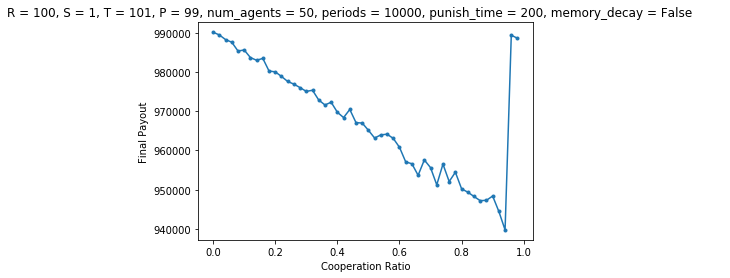

Ratio 1.0103092783505154


In [136]:
bb_5 = run_big_brain(50, 10000, payoff_map_5, 200, False)
bb_5.run()
bb_5.summarize()
bb_5.graph_results()

In [141]:
payoff_map_6 = {
    
    ## Reward for both cooperate
    'R': 10000,
    
    ## Sucker cooperate alone
    'S': 1000,
    
    ## Tempation to defect alone
    'T': 10001,
    
    ## Punishment when both defect
    'P': 1001.0001,
}
    

Total Payout 629230742.4171443


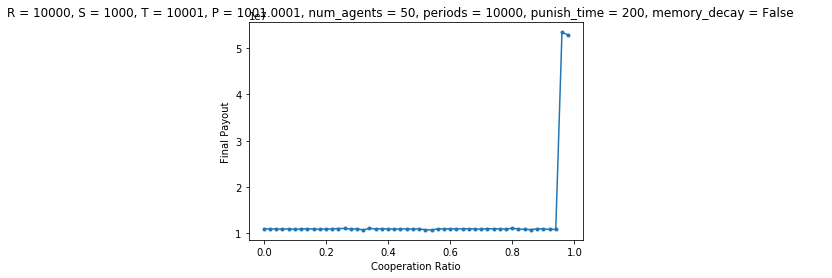

Ratio 10001.00007072913


In [142]:
bb_6 = run_big_brain(50, 10000, payoff_map_6, 200, False)
bb_6.run()
bb_6.summarize()
bb_6.graph_results()

In [146]:
class run_med_brain:
    
    
    def __init__(self, num_players, periods, payout_map, punish_time, memory_adjustment=False):
        
        
        self.N = num_players
        self.T = periods
        self.payout_map = payout_map
        
        ##let punish time also be number of periods we play until new vote
        self.punish_time = punish_time
        self.decay_memory = memory_adjustment
        
        ##create agents vector
        self.agents_vec = []
        for i in range(self.N):
            new_agent = big_brain_agent(i, self.N)
            self.agents_vec.append(new_agent)
    
    def run(self):
        
        for t in range(self.T):
                
            ## if in right period vote
            if t%self.punish_time == 0 and t != 0:
                self.vote(t)
            
            
            ## play the game
            
            #initialize map of all players
            unpaired_players = set(np.arange(self.N))
            
            ## let them play
            while len(unpaired_players) > 1:
                p1_ID = random.sample(unpaired_players, 1)[0]
                unpaired_players.remove(p1_ID)
                p2_ID = random.sample(unpaired_players, 1)[0]
                unpaired_players.remove(p2_ID)
                
                p1 = self.agents_vec[p1_ID]
                p2 = self.agents_vec[p2_ID]
            
                self.update_agents(p1, p2, t)
            
            
    def update_agents(self, p1, p2, time):
        
        ## let's normalize cooperate as 1 and default as -1
        choice_map = {
            'C': 1,
            'D': -1
        }
        
        
        ## they play
        p1_choice = p1.strategy()
        p2_choice = p2.strategy()
        
        ## however if one of them is on probation switch strategy to defect
        if p1.probation == True:
            p2_choice = 'D'
        if p2.probation == True:
            p1_choice = 'D'
        
        
        ## they update
        p1.other_history[p2.ID].append(choice_map[p2_choice])
        p2.other_history[p1.ID].append(choice_map[p1_choice])
    
        payouts = self.calculate_payouts(p1_choice, p2_choice)
        p1.total_payout += payouts[0]
        p2.total_payout += payouts[1]
        
        
    def calculate_payouts(self, p1_choice, p2_choice):
        
        ## both cooperate
        if p1_choice == 'C' and p2_choice == 'C':
            return (self.payout_map['R'], self.payout_map['R'])
        
        ## both defect
        elif p1_choice == 'D' and p2_choice == 'D':
            return (self.payout_map['P'], self.payout_map['P'])
        
        ## p1 cooperates and p2 defects
        elif p1_choice == 'C' and p2_choice == 'D':
            return (self.payout_map['S'], self.payout_map['T'])
        
        ## p2 cooperates and p1 defects
        else:
            return (self.payout_map['T'], self.payout_map['S'])
    
    def vote(self, cur_t):
        ## note that people on probation do not get to vote
        ## at this interval, people get a binary vote on whether or not they want to put someone on probation
        ## if a majority agree then they are, else they are not
        
        for agent in self.agents_vec:
            cur_ID = agent.ID
            votes_for = 0
            votes_against = 0
            
            ##loop through agents
            for voter in self.agents_vec:
                
                ## skip if you are on probation and can't vote for yourself
                if voter.probation == True:
                    
                    ## clear history
                    #voter.other_history[cur_ID] = []
                    
                    continue
            
                ## access your history with this guy
                history = voter.other_history[cur_ID]
                count_C = history.count(1)
                count_D = history.count(-1)
                
                ### change voting strategy here
                R = self.payout_map['R']
                S = self.payout_map['S']
                T = self.payout_map['T']
                P = self.payout_map['P']
                
                if count_C + count_D < 1:
                    decision = 'C'
                
                else:
                    if count_C / (count_C + count_D) < voter.initial_coop_ratio:
                        decision = 'D'
                    else:
                        decision = 'C'
                
                if decision == 'D':
                    votes_against += 1
                else:
                    votes_for += 1

                ## ????clear history after voting
                #voter.other_history[cur_ID] = []
                    
            ## determine whether this agent should be put on prob or not
            if votes_against > votes_for:
                agent.probation = True
            else:
                agent.probation = False
                
                
    def summarize(self):
        
        self.summary_list = []
        
        
        for a in self.agents_vec:
            coop_ratio = a.initial_coop_ratio
            payout = a.total_payout
            
            new_entry = {
                'Cooperation_Ratio': coop_ratio,
                'Final_Payout': payout
            }
            self.summary_list.append(new_entry)
            
        self.summary_df = pd.DataFrame(self.summary_list)
        
    def graph_results(self):
        
        
        plt.plot(self.summary_df['Cooperation_Ratio'], self.summary_df['Final_Payout'], '.-')
        
        
        p_map = self.payout_map
        
        title_str = "R = {}, S = {}, T = {}, P = {}, num_agents = {}, periods = {}, punish_time = {}, memory_decay = {}\
        ".format(p_map['R'],p_map['S'],p_map['T'],p_map['P'], self.N, self.T, self.punish_time, self.decay_memory)
        
        
        plt.title(title_str)
        plt.xlabel('Cooperation Ratio')
        plt.ylabel('Final Payout')
    
        total_util = sum(self.summary_df['Final_Payout'])
        print('Total Payout', total_util)
        plt.show()


Total Payout 1107728


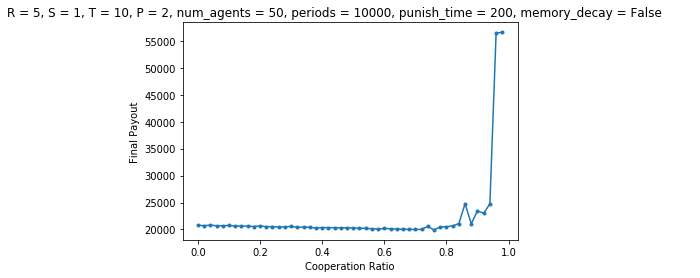

In [147]:
mm_1 = run_med_brain(50, 10000, payoff_map_1, 200, False)
mm_1.run()
mm_1.summarize()
mm_1.graph_results()

Total Payout 2339716


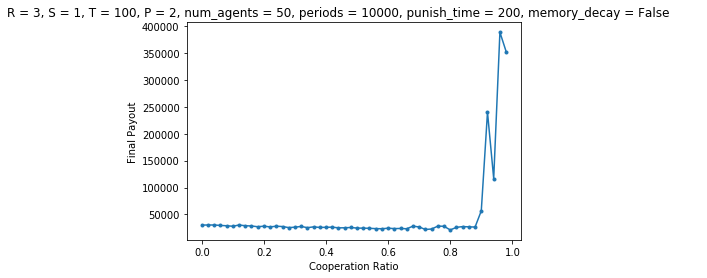

In [148]:
mm_3 = run_med_brain(50, 10000, payoff_map_3, 200, False)
mm_3.run()
mm_3.summarize()
mm_3.graph_results()

Total Payout 48188488


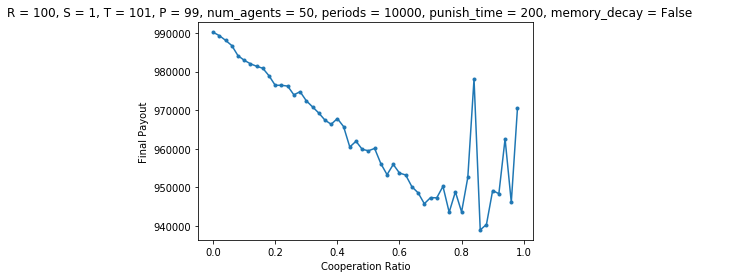

In [152]:
mm_5 = run_med_brain(50, 10000, payoff_map_5, 200, False)
mm_5.run()
mm_5.summarize()
mm_5.graph_results()

Total Payout 657532596.8917418


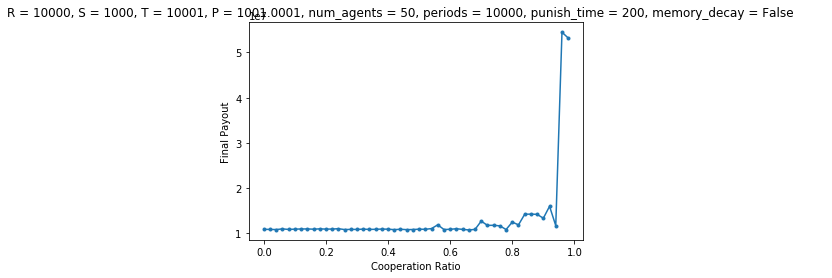

In [153]:
mm_5 = run_med_brain(50, 10000, payoff_map_6, 200, False)
mm_5.run()
mm_5.summarize()
mm_5.graph_results()